In [2]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from datetime import datetime
from nltk.tokenize import sent_tokenize
import fasttext
import pandas as pd
import string
import nltk

%matplotlib inline

In [3]:
# load file
file_Name = './data/url_tweets_news_100k.p'
fileObject = open(file_Name,'rb')  
p1 = pickle.load(fileObject)

# stop_words = []
# with open('./util/stop_words.txt') as f:
#     for line in f:
#         stop_words.append(line.strip())

In [4]:
file_Name2 = './data/news_tweets_120k.p'
fileObject2 = open(file_Name2,'rb')  
p2 = pickle.load(fileObject2)
p = {**p1, **p2}
len(p)

221147

In [5]:
# statistics for tweets series 
MAX_SPAN =  24 # in hours
INTERVAL = 0.5 # in hours

# Load data and form basic dataframe

In [6]:
punctuation = set(string.punctuation)
from string import ascii_letters, digits

def ExtractAlphanumeric(InputString):
    return "".join([ch for ch in InputString if ch in (ascii_letters + digits+''.join(punctuation)+' '+'\n')])

def cut_sentences(text, min_len, max_len):
    text = ExtractAlphanumeric(text)
    paragraph_list = text.split('\n\n')
    sent_list = [sent_tokenize(i) for i in paragraph_list]
    sent_list = [y for x in sent_list for y in x]
    sent_list = [''.join([j for j in i if j not in punctuation]) for i in sent_list]
    return [i for i in sent_list if len(i)<max_len and len(i)>min_len]

def cut_paragraphs(text, min_len, max_len):
    text = ExtractAlphanumeric(text)
    paragraph_list = text.split('\n\n')
#     paragraph_list = [''.join([j for j in i if j not in punctuation]) for i in paragraph_list]
    return [i for i in paragraph_list if len(i)<max_len and len(i)>min_len]

In [7]:
# form basic dataframe
df = pd.DataFrame({'url': list(p.keys())})
df['news_text'] = df['url'].apply(lambda x: p[x]['news']['text'])
df['news_title'] = df['url'].apply(lambda x: p[x]['news']['title'])
df['news_publish_timestamp_ms'] = df['url'].apply(lambda x: p[x]['news']['publish_timestamp_ms'])
df['publisher'] = df['url'].apply(lambda x: x.split('/')[2].replace('www.',''))
df['news_publish_datetime'] = df['news_publish_timestamp_ms'].apply(lambda x: datetime.fromtimestamp(x/1000))
df['sentences'] = df['news_text'].apply(lambda x: cut_sentences(x, 30, 400))
df['num_sentences'] = df['sentences'].apply(lambda x: len(x))
# df['news_tokens'] = df['news_text'].apply(lambda x: nltk.word_tokenize(''.join(i for i in x if ord(i)<256)))
# df['news_len'] = df['news_tokens'].apply(lambda x: len(x))
# df['news_words'] = df['news_tokens'].apply(lambda x: [i.lower() for i in x if i.lower() not in stop_words and len(i)>1])
df['amount_tweets'] = df['url'].apply(lambda x: len(p[x]['tweets']))
df['news_publish_year'] = df['news_publish_datetime'].apply(lambda x: x.year)
df['news_lifespan_h'] = df['url'].apply(lambda x: ((p[x]['tweets'][-1]['timestamp_ms'] - p[x]['tweets'][0]['timestamp_ms'])/1000/3600))

print('Number of news is:', len(df))

Number of news is: 221147


In [10]:
num_sent = list(df.groupby(['num_sentences']).count().index)
num_num_sent = list(df.groupby(['num_sentences']).count()['url'])

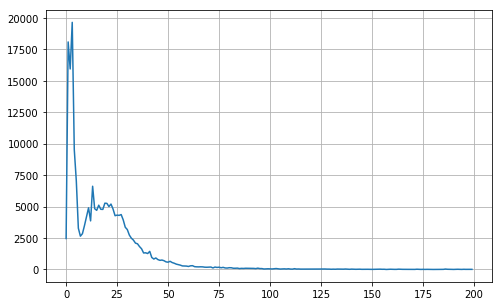

In [11]:
plt.figure(figsize = (8,5))
plt.plot(num_sent[:200], num_num_sent[:200])
plt.grid()
plt.show()

# Clean news

In [12]:
def truncate_sent(x):
    if x['num_sentences']>50:
        return x['sentences'][:50]
    else:
        return x['sentences']

df1 = df.copy()
# clean news: remove wrong time data; remove non-alphabetic news;
# check urls
publishers = []
with open('./util/publisher.txt') as f:
    for i in f:
        publishers.append(i.strip())
df1['check_url'] = df1['publisher'].apply(lambda x: 1 if x in publishers else 0)
df1 = df1[df1['check_url']==1]

# short news: there are also many short news < 100 words but >100 comment, most ads.
# ************as we are not talking about tweet span in the first part, we do not consider life span.***********
# # for enough life_span:
# df1 = df1[df1['news_lifespan_h']>MAX_SPAN]
# for right publish year: 
df1 = df1[df1['news_publish_year']>2017]
df1 = df1[df1['news_publish_year']<2020]
# for proper length of news:
df1 = df1[df1['num_sentences'] > 5]
# trunctuate long news: 94.14% of news are shorter than 50 sentences; if a news longer
# than 50 sentences, we just keep first 50 sentences of it.
df1['sentences'] = df1.apply(lambda x: truncate_sent(x), axis=1)
df1['num_sentences'] = df1['sentences'].apply(lambda x: len(x))

In [13]:
df1 = df1.reset_index(drop=True)

In [14]:
num = list(df1['amount_tweets'])
sum([1 for i in num if i>20])

3379

In [15]:
df1.to_pickle('./data/cleaned_data.pkl')

In [8]:
df1=pd.read_pickle('./data/cleaned_data.pkl')

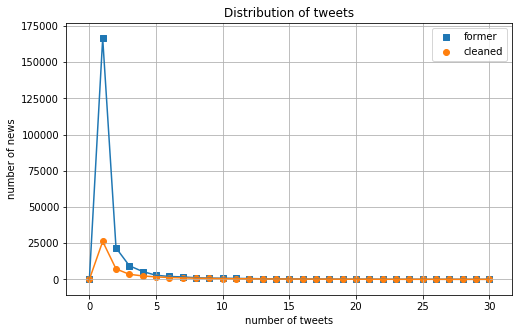

In [14]:
list_tweet_num = list(df['amount_tweets'])
tweet_num = list(df1['amount_tweets'])
t = np.linspace(0, 30, 31)
d = []
d1 = []
for i in t:
    d.append(sum([1 for num in list_tweet_num if num == i]))
    d1.append(sum([1 for num in tweet_num if num == i]))
    
plt.figure(figsize = (8,5))
l1 = plt.plot(t,d)
plt.scatter(t,d,marker='s', label = 'former')
l2 = plt.plot(t,d1)
plt.scatter(t,d1, label='cleaned')
plt.xlabel('number of tweets')
plt.ylabel('number of news')
plt.title('Distribution of tweets')
plt.grid(which='major')
plt.legend(loc='upper right')
foo_fig = plt.gcf()
foo_fig.savefig('distribution.eps', format='eps', dpi=1000)

# clean json data

In [17]:
url_list = list(df1['url'])
cleaned_dict = {}
for i in url_list:
    cleaned_dict[i] = p[i]

In [18]:
with open('./data/220k_cleaned.p','wb') as f:
    pickle.dump(cleaned_dict, f, protocol=pickle.HIGHEST_PROTOCOL)